# ⚽ Team Performance Score Analysis

This notebook introduces and visualizes a **custom Performance Score** that evaluates a football team’s overall impact during a match. The score is designed to provide a more comprehensive understanding of performance beyond just goals or possession stats.

### 🧠 What is the Performance Score?

The **Performance Score** is a composite metric that combines multiple key indicators:
- 🥅 Goals Scored
- 🎯 Shots & Shots on Target
- 📊 Expected Goals (xG)
- 🔁 Successful Passes

Each component contributes to the overall score based on predefined weights that reflect their importance in evaluating match dominance. All values are **normalized**, allowing fair comparison across teams, matches, and time intervals.

### 📈 Why Use a Custom Score?

This approach offers:
- A **balanced view** of performance, not skewed by a single stat.
- The ability to compare **different matches or teams** consistently.
- Insights into how **underlying metrics** (like xG or passing success) influence match outcomes.

### 📊 Visualizations

Interactive visualizations built with **Plotly** provide:
- Team comparisons per match
- Trends over time
- Home vs Away breakdowns
- Statistical contributions to the final score

---

This tool is useful for analysts, coaches, and enthusiasts aiming to understand the full picture of match performance through a data-driven lens.


## Import Libraries

In [75]:
from statsbombpy import sb
import pandas as pd
import numpy as np
#from mplsoccer import Pitch
from mplsoccer import VerticalPitch,Pitch
from mplsoccer.pitch import Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import math
import matplotlib.patches as mpatches
import plotly.graph_objects as go
from functools import reduce
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
pd.set_option("display.max_columns", None)

### Euro 2024 Competition

In [76]:
#call the statsbombpy API to get a list of matches for a given competition
euro_2024_matches = sb.matches(competition_id=55, season_id=282)

#print the first 5 matches listed
euro_2024_matches.head(5)

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3942819,2024-07-10,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,England,1,2,available,available,2024-07-15T07:54:23.583297,2024-07-15T07:57:36.684453,6,Semi-finals,Signal-Iduna-Park,Felix Zwayer,Ronald Koeman,Gareth Southgate,1.1.0,2,2
1,3943043,2024-07-14,22:00:00.000,Europe - UEFA Euro,2024,Spain,England,2,1,available,available,2024-07-15T15:48:50.315500,2024-07-15T15:52:24.778809,7,Final,Olympiastadion Berlin,François Letexier,Luis de la Fuente Castillo,Gareth Southgate,1.1.0,2,2
2,3942752,2024-07-09,22:00:00.000,Europe - UEFA Euro,2024,Spain,France,2,1,available,available,2024-07-10T08:51:07.032303,2024-07-10T13:01:26.597509,6,Semi-finals,Allianz Arena,Slavko Vinčić,Luis de la Fuente Castillo,Didier Deschamps,1.1.0,2,2
3,3942382,2024-07-06,22:00:00.000,Europe - UEFA Euro,2024,Netherlands,Turkey,2,1,available,available,2024-07-10T06:50:04.068615,2024-07-10T06:56:35.146850,5,Quarter-finals,Olympiastadion Berlin,Clément Turpin,Ronald Koeman,Vincenzo Montella,1.1.0,2,2
4,3942349,2024-07-05,22:00:00.000,Europe - UEFA Euro,2024,Portugal,France,0,0,available,available,2024-07-12T01:57:15.210934,2024-07-12T02:00:16.871522,5,Quarter-finals,Volksparkstadion,Michael Oliver,Roberto Martínez Montoliú,Didier Deschamps,1.1.0,2,2


## ETL

In [77]:
#concat home and away teams to keep the unique teams that participated to the tournament
home_team = euro_2024_matches['home_team']
away_team = euro_2024_matches['away_team']
teams = pd.concat([home_team,away_team])
teams = pd.DataFrame(teams.drop_duplicates()).reset_index(drop=True)
teams.columns = ['Team']

In [78]:
# give teams colors for the visuals
team_colors = pd.read_excel('Team Colors.xlsx')
teams = teams.merge(team_colors, how='inner', on='Team')

In [79]:
teams.head()

,Team,First_Color,Second_Color
0,Netherlands,#F36C21,#FFFFFF
1,Spain,#8B0D11,#FCB507
2,Portugal,#E42518,#0D6938
3,Denmark,#FCB507,#FFFFFF
4,England,#012169,#FFFFFF


In [80]:
# take all matches in one dataframe
matches = euro_2024_matches.filter(['match_id','match_date','home_team','away_team','competition_stage','home_score','away_score','period'])
matches['match'] = matches['competition_stage'] + ' ' + matches['home_team'] + ' - ' + matches['away_team'] 

In [81]:
matches

,match_id,match_date,home_team,away_team,competition_stage,home_score,away_score,match
0,3942819,2024-07-10,Netherlands,England,Semi-finals,1,2,Semi-finals Netherlands - England
1,3943043,2024-07-14,Spain,England,Final,2,1,Final Spain - England
2,3942752,2024-07-09,Spain,France,Semi-finals,2,1,Semi-finals Spain - France
3,3942382,2024-07-06,Netherlands,Turkey,Quarter-finals,2,1,Quarter-finals Netherlands - Turkey
4,3942349,2024-07-05,Portugal,France,Quarter-finals,0,0,Quarter-finals Portugal - France
5,3930180,2024-06-25,Netherlands,Austria,Group Stage,2,3,Group Stage Netherlands - Austria
6,3930171,2024-06-20,Denmark,England,Group Stage,1,1,Group Stage Denmark - England
7,3942227,2024-07-06,England,Switzerland,Quarter-finals,1,1,Quarter-finals England - Switzerland
8,3942226,2024-07-05,Spain,Germany,Quarter-finals,2,1,Quarter-finals Spain - Germany
9,3938645,2024-06-26,Ukraine,Belgium,Group Stage,0,0,Group Stage Ukraine - Belgium


In [82]:
# retrieve the prefered Match ID
def take_matchid(df, value):
    match = df[df['match'] == value]
    if not match.empty:
        return match['match_id'].iloc[0]
    else:
        return None  # or handle it as you need

# select the match that you want 
def teams_selected(df,value):
    df_details = df[df.match == value]
    return df_details

In [112]:
# choose a match from table (matches) and column (match)
match_selector = 'Final Spain - England'#'Quarter-finals England - Switzerland'#'Final Spain - England'

In [113]:
# call the statsbombpy events API to bring in the event data for the match using the function and the string match_selector
match = sb.events(match_id=take_matchid(matches,match_selector))

In [114]:
match.head()

,50_50,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,block_offensive,block_save_block,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,clearance_right_foot,counterpress,dribble_nutmeg,dribble_outcome,dribble_overrun,duel_outcome,duel_type,duration,foul_committed_advantage,foul_committed_card,foul_committed_offensive,foul_won_advantage,foul_won_defensive,goalkeeper_body_part,goalkeeper_end_location,goalkeeper_outcome,goalkeeper_position,goalkeeper_technique,goalkeeper_type,id,index,injury_stoppage_in_chain,interception_outcome,location,match_id,minute,off_camera,out,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_end_location,pass_goal_assist,pass_height,pass_inswinging,pass_length,pass_no_touch,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,period,play_pattern,player,player_id,position,possession,possession_team,possession_team_id,related_events,second,shot_aerial_won,shot_body_part,shot_deflected,shot_end_location,shot_first_time,shot_freeze_frame,shot_key_pass_id,shot_one_on_one,shot_outcome,shot_statsbomb_xg,shot_technique,shot_type,substitution_outcome,substitution_outcome_id,substitution_replacement,substitution_replacement_id,tactics,team,team_id,timestamp,type,under_pressure
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50aa204f-5d65-4145-8597-5d5628fb7898,1,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",Spain,772,00:00:00.000,Starting XI,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a279cbee-9ab3-4cfb-9c51-27cacc1bf2a2,2,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'formation': 4231, 'lineup': [{'player': {'id...",England,768,00:00:00.000,Starting XI,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d2126e70-9f04-4bb7-ba2b-9377836d1757,3,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,[54d78bfa-4146-42bd-acdc-97bcd393dd81],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54d78bfa-4146-42bd-acdc-97bcd393dd81,4,NaN,NaN,NaN,3943043,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Regular Play,NaN,NaN,NaN,1,Spain,772,[d2126e70-9f04-4bb7-ba2b-9377836d1757],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,772,00:00:00.000,Half Start,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7230470a-8ceb-4eb8-a66f-d72a2afb12d6,1706,NaN,NaN,NaN,3943043,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Regular Play,NaN,NaN,NaN,79,Spain,772,[cb9ba06c-a673-448d-ab21-755d330fcadc],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,England,768,00:00:00.000,Half Start,NaN


In [115]:
# retieve the general info of the match using again the other function and the match selector
match_details = teams_selected(matches,match_selector)

In [116]:
match_details

,match_id,match_date,home_team,away_team,competition_stage,home_score,away_score,match
1,3943043,2024-07-14,Spain,England,Final,2,1,Final Spain - England


In [117]:
# make a new column minute_per_15 to capture in which interval the match is
def interval_minute(row):
    if row['period'] == 1 and row['minute'] > 45:
        return 45
    elif row['period'] == 2 and row['minute'] > 90:
        return 90
    elif row['period'] == 3 and row['minute'] > 105:
        return 105
    elif row['period'] == 4 and row['minute'] > 120:
        return 120
    else:
        return row['minute']

match['interval_minute'] = match.apply(interval_minute, axis=1)

# Step 2: Make sure 0 becomes 15
match['minute_per_15'] = np.ceil(match['interval_minute'].clip(lower=1) / 15) * 15
match['minute_per_15'] = match['minute_per_15'].astype(int)

## Team Colors

In [118]:
#concat home and away teams to keep the unique teams that participated to the tournament
home_team = euro_2024_matches['home_team']
away_team = euro_2024_matches['away_team']
teams = pd.concat([home_team,away_team])
teams = pd.DataFrame(teams.drop_duplicates()).reset_index(drop=True)
teams.columns = ['Team']

In [119]:
# give teams colors for the visuals
team_colors = pd.read_excel('Team Colors.xlsx')
teams = teams.merge(team_colors, how='inner', on='Team')

In [120]:
teams.head()

,Team,First_Color,Second_Color
0,Netherlands,#F36C21,#FFFFFF
1,Spain,#8B0D11,#FCB507
2,Portugal,#E42518,#0D6938
3,Denmark,#FCB507,#FFFFFF
4,England,#012169,#FFFFFF


In [121]:
home_team = str(match_details['home_team'].iloc[0])
home_color = teams[teams['Team'] == home_team]['First_Color'].values[0]
away_team = str(match_details['away_team'].iloc[0])
away_color = teams[teams['Team'] == away_team]['Second_Color'].values[0]

In [122]:
print(f'Home Team Color code : {home_color}  Away Team Color code : {away_color}')

Home Team Color code : #8B0D11  Away Team Color code : #FFFFFF


# Analysis

In [123]:
# exclude penalties
match = match[match['period'] != 5]

In [124]:
teams_in_match = match['team'].unique()

# Create a function to get the opposing team
def get_opposing_team(team):
    return [t for t in teams_in_match if t != team][0]

# Create goal tracking with proper own goal handling
match['goal'] = 0  # Initialize all as 0

# Handle regular goals
regular_goals = (match['shot_outcome'] == 'Goal')
match.loc[regular_goals, 'goal'] = 1

# Handle own goals - create separate records for the benefiting team
own_goals = match[match['type'] == 'Own Goal Against'].copy()

if not own_goals.empty:
    # For each own goal, create a new record crediting the opposing team
    own_goal_records = []
    
    for idx, row in own_goals.iterrows():
        # Create a new record for the opposing team
        new_record = row.copy()
        new_record['team'] = get_opposing_team(row['team'])
        new_record['goal'] = 1
        own_goal_records.append(new_record)
    
    # Convert to DataFrame and append to match data
    own_goal_df = pd.DataFrame(own_goal_records)
    match_with_own_goals = pd.concat([match, own_goal_df], ignore_index=True)
else:
    match_with_own_goals = match.copy()

# Now group by team and minute_per_15 to get goals
goals_by_team_minute = match_with_own_goals.groupby(['team', 'minute_per_15'])['goal'].sum().reset_index()
goals_by_team_minute.rename(columns={'goal': 'goals'}, inplace=True)

In [125]:
goals_by_team_minute

,team,minute_per_15,goals
0,England,15,0
1,England,30,0
2,England,45,0
3,England,60,0
4,England,75,1
5,England,90,0
6,Spain,15,0
7,Spain,30,0
8,Spain,45,0
9,Spain,60,1


In [126]:
# sucessful passes per 15 minutes
passes_complete = match[match['type'] == 'Pass']
passes_complete = passes_complete[passes_complete['pass_outcome'].isnull()]
passes_complete = passes_complete.groupby(['team', 'minute_per_15'])['type'].count().reset_index()
passes_complete.rename(columns={'type': 'successful_passes'}, inplace=True)

In [127]:
passes_complete

,team,minute_per_15,successful_passes
0,England,15,36
1,England,30,39
2,England,45,37
3,England,60,76
4,England,75,45
5,England,90,21
6,Spain,15,110
7,Spain,30,87
8,Spain,45,101
9,Spain,60,87


In [128]:
# xgoals per 15 minutes
xgoals_by_team_minute = match.groupby(['team', 'minute_per_15'])['shot_statsbomb_xg'].sum().reset_index()
xgoals_by_team_minute.rename(columns={'shot_statsbomb_xg': 'xgoals'}, inplace=True)
xgoals_by_team_minute

,team,minute_per_15,xgoals
0,England,15,0.000000
1,England,30,0.048995
2,England,45,0.228066
3,England,60,0.000000
4,England,75,0.168938
5,England,90,0.280378
6,Spain,15,0.185495
7,Spain,30,0.048117
8,Spain,45,0.104909
9,Spain,60,0.675589


In [129]:
# shots per 15 minutes
shots = (
    match[match['shot_outcome'].notnull()]
    .groupby(['team', 'minute_per_15'])['shot_outcome']
    .count()
    .reset_index(name='shots')
)

teams = match['team'].unique()
minutes = match['minute_per_15'].unique()

full_index = pd.MultiIndex.from_product([teams, minutes], names=['team', 'minute_per_15'])
shots = shots.set_index(['team', 'minute_per_15']).reindex(full_index, fill_value=0).reset_index()
shots

,team,minute_per_15,shots
0,Spain,15,2
1,Spain,45,2
2,Spain,30,1
3,Spain,60,5
4,Spain,75,4
5,Spain,90,2
6,England,15,0
7,England,45,2
8,England,30,1
9,England,60,0


In [130]:
# shots on target per 15 minutes
filtered = match[match['shot_outcome'].isin(['Saved', 'Goal'])]

# Step 2: Group and count
shots_on_tar = (
    filtered.groupby(['team', 'minute_per_15'])['shot_outcome']
    .count()
    .reset_index(name='shots_on_tar')
)

# Step 3: Create all combinations of team × minute_per_15
teams = match['team'].unique()
minutes = match['minute_per_15'].unique()
full_index = pd.MultiIndex.from_product([teams, minutes], names=['team', 'minute_per_15'])

# Step 4: Reindex to include 0s where no 'Saved' or 'Goal' shots occurred
shots_on_tar = shots_on_tar.set_index(['team', 'minute_per_15']).reindex(full_index, fill_value=0).reset_index()
shots_on_tar

,team,minute_per_15,shots_on_tar
0,Spain,15,0
1,Spain,45,0
2,Spain,30,1
3,Spain,60,1
4,Spain,75,2
5,Spain,90,2
6,England,15,0
7,England,45,1
8,England,30,0
9,England,60,0


In [131]:
# combine all data in one table
# List of all DataFrames to merge
dfs = [goals_by_team_minute, xgoals_by_team_minute, passes_complete, shots, shots_on_tar]

# Merge them on 'team' and 'minute_per_15'
stats_per_15 = reduce(lambda left, right: pd.merge(left, right, on=['team', 'minute_per_15'], how='outer'), dfs)

# Fill NaNs with 0 for any missing values (optional, if all columns are numeric)
stats_per_15 = stats_per_15.fillna(0)

In [132]:
stats_per_15

,team,minute_per_15,goals,xgoals,successful_passes,shots,shots_on_tar
0,England,15,0,0.000000,36,0,0
1,England,30,0,0.048995,39,1,0
2,England,45,0,0.228066,37,2,1
3,England,60,0,0.000000,76,0,0
4,England,75,1,0.168938,45,3,1
5,England,90,0,0.280378,21,3,1
6,Spain,15,0,0.185495,110,2,0
7,Spain,30,0,0.048117,87,1,1
8,Spain,45,0,0.104909,101,2,0
9,Spain,60,1,0.675589,87,5,1


In [133]:
# put weights per category to check the teams performance
weights = {
    'goals': 0.35,
    'xgoals': 0.25,
    'shots_on_tar': 0.20,
    'shots': 0.15,
    'successful_passes': 0.10
}

In [134]:
# Columns to normalize and weight
metrics = ['goals', 'xgoals', 'shots_on_tar', 'shots', 'successful_passes']

# Normalize each metric
scaler = MinMaxScaler()
stats_per_15_scaled = pd.DataFrame(scaler.fit_transform(stats_per_15[metrics]), columns=[f"{col}_norm" for col in metrics])

# Apply weights and compute performance score
for metric in metrics:
    stats_per_15[f"{metric}_norm"] = stats_per_15_scaled[f"{metric}_norm"] * weights[metric]

# Sum all normalized weighted metrics into a final score
stats_per_15['performance_score'] = stats_per_15[[f"{m}_norm" for m in metrics]].sum(axis=1)

In [135]:
stats_per_15

,team,minute_per_15,goals,xgoals,successful_passes,shots,shots_on_tar,goals_norm,xgoals_norm,shots_on_tar_norm,shots_norm,successful_passes_norm,performance_score
0,England,15,0,0.000000,36,0,0,0.00,0.000000,0.0,0.00,0.016854,0.016854
1,England,30,0,0.048995,39,1,0,0.00,0.018131,0.0,0.03,0.020225,0.068355
2,England,45,0,0.228066,37,2,1,0.00,0.084395,0.1,0.06,0.017978,0.262373
3,England,60,0,0.000000,76,0,0,0.00,0.000000,0.0,0.00,0.061798,0.061798
4,England,75,1,0.168938,45,3,1,0.35,0.062515,0.1,0.09,0.026966,0.629481
5,England,90,0,0.280378,21,3,1,0.00,0.103753,0.1,0.09,0.000000,0.293753
6,Spain,15,0,0.185495,110,2,0,0.00,0.068642,0.0,0.06,0.100000,0.228642
7,Spain,30,0,0.048117,87,1,1,0.00,0.017806,0.1,0.03,0.074157,0.221963
8,Spain,45,0,0.104909,101,2,0,0.00,0.038821,0.0,0.06,0.089888,0.188709
9,Spain,60,1,0.675589,87,5,1,0.35,0.250000,0.1,0.15,0.074157,0.924157


In [136]:
# Normalize performance score within each minute interval
stats_per_15['normalized_score'] = stats_per_15.groupby('minute_per_15')['performance_score'].transform(
    lambda x: x / x.sum() if x.sum() != 0 else 0
)
stats_per_15

,team,minute_per_15,goals,xgoals,successful_passes,shots,shots_on_tar,goals_norm,xgoals_norm,shots_on_tar_norm,shots_norm,successful_passes_norm,performance_score,normalized_score
0,England,15,0,0.000000,36,0,0,0.00,0.000000,0.0,0.00,0.016854,0.016854,0.068653
1,England,30,0,0.048995,39,1,0,0.00,0.018131,0.0,0.03,0.020225,0.068355,0.235449
2,England,45,0,0.228066,37,2,1,0.00,0.084395,0.1,0.06,0.017978,0.262373,0.581653
3,England,60,0,0.000000,76,0,0,0.00,0.000000,0.0,0.00,0.061798,0.061798,0.062678
4,England,75,1,0.168938,45,3,1,0.35,0.062515,0.1,0.09,0.026966,0.629481,0.577664
5,England,90,0,0.280378,21,3,1,0.00,0.103753,0.1,0.09,0.000000,0.293753,0.254656
6,Spain,15,0,0.185495,110,2,0,0.00,0.068642,0.0,0.06,0.100000,0.228642,0.931347
7,Spain,30,0,0.048117,87,1,1,0.00,0.017806,0.1,0.03,0.074157,0.221963,0.764551
8,Spain,45,0,0.104909,101,2,0,0.00,0.038821,0.0,0.06,0.089888,0.188709,0.418347
9,Spain,60,1,0.675589,87,5,1,0.35,0.250000,0.1,0.15,0.074157,0.924157,0.937322


In [137]:
# Compute cumulative goals per team
goals_cum = goals_by_team_minute.copy()
goals_cum['cumulative_goals'] = goals_cum.groupby('team')['goals'].cumsum()

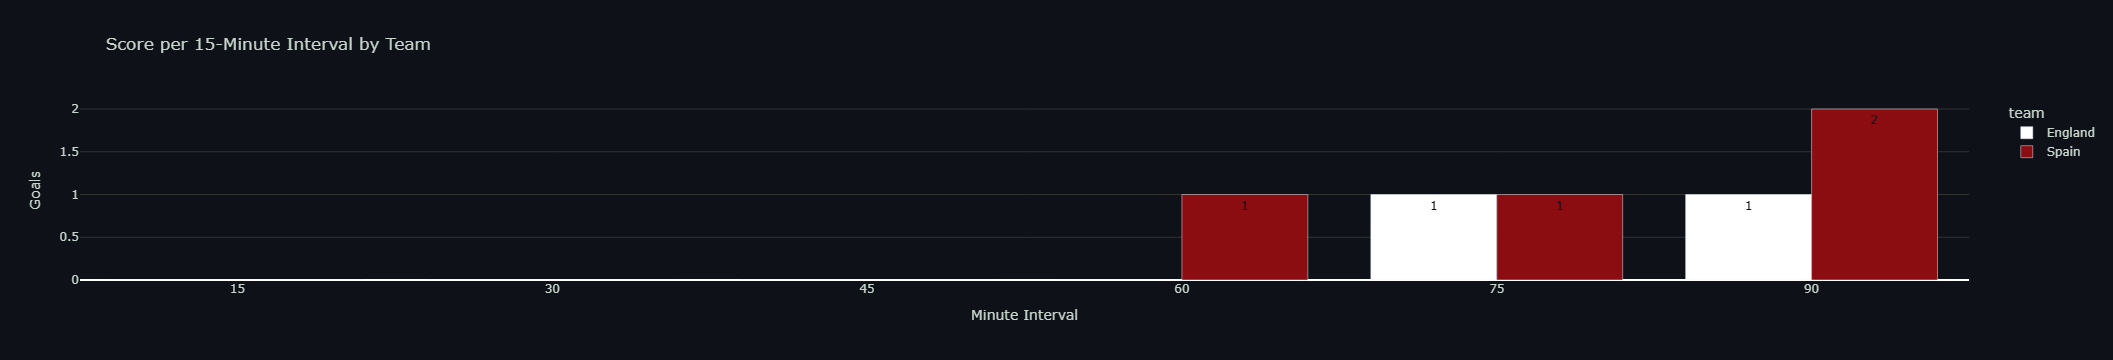

In [138]:
fig = px.bar(
    goals_cum,
    x='minute_per_15',
    y='cumulative_goals',
    color='team',
    barmode='group',
    title='Score per 15-Minute Interval by Team',
    labels={'minute_per_15': 'Minute Interval', 'cumulative_goals': 'Goals'},
    color_discrete_map={
        home_team : home_color,  
        away_team : away_color     
    }
)

# Apply dark theme
fig.update_layout(
    plot_bgcolor='#0E1117',
    paper_bgcolor='#0E1117',
    font=dict(color='#c7d5cc'),
    xaxis=dict(type='category', showgrid=False, color='#c7d5cc'),
    yaxis=dict(gridcolor='#333', color='#c7d5cc'),
    legend=dict(font=dict(color='#c7d5cc')),
    title_font=dict(color='#c7d5cc')
)

fig.update_traces(
    texttemplate='%{y}',                 
    textposition='inside',
    insidetextfont=dict(color='#0E1117')     
)


fig.show()


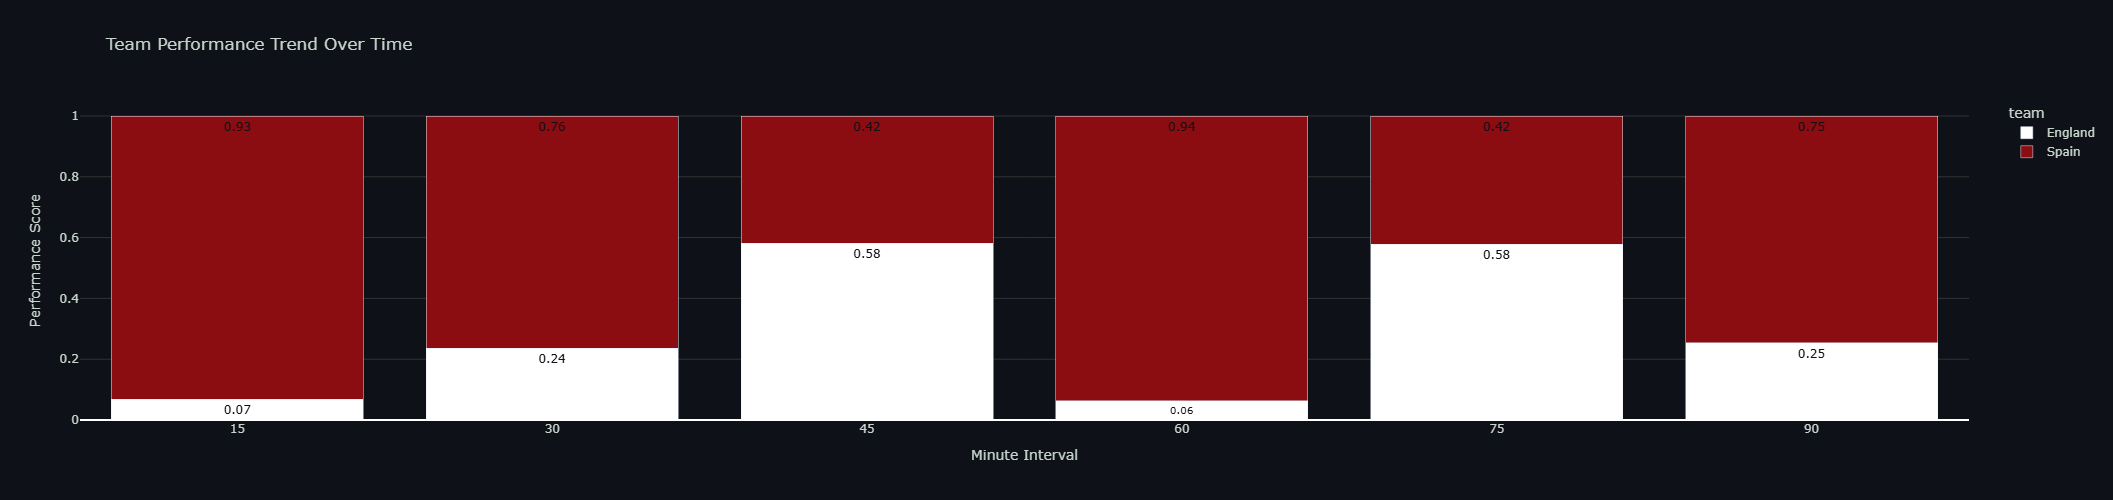

In [142]:
# Plot the stacked percentage chart
fig = px.bar(
    stats_per_15,
    x='minute_per_15',
    y='normalized_score',
    color='team',
    barmode='stack',
    title='Team Performance Trend Over Time',
    labels={'minute_per_15': 'Minute Interval', 'normalized_score': 'Performance Score'},
    height=500,
    color_discrete_map={
        home_team : home_color,  
        away_team : away_color     
    }
)

# Apply dark theme
fig.update_layout(
    plot_bgcolor='#0E1117',
    paper_bgcolor='#0E1117',
    font=dict(color='#c7d5cc'),
    xaxis=dict(type='category', showgrid=False, color='#c7d5cc'),
    yaxis=dict(showgrid=True, gridcolor='#333', color='#c7d5cc'),
    legend=dict(font=dict(color='#c7d5cc')),
    title_font=dict(color='#c7d5cc')
)


fig.update_traces(
    texttemplate='%{y:.2f}',                  
    textposition='inside',
    insidetextfont=dict(color='#0E1117')     
)

fig.show()

In [140]:
# Line chart showing trends
fig = px.line(
    stats_per_15,
    x='minute_per_15',
    y='normalized_score',
    color='team',
    markers=True,
    title='Team Performance Trend Over Time',
    labels={'minute_per_15': 'Minute Interval', 'normalized_score': 'Proportional Performance'},
    color_discrete_map={
        home_team : home_color,  
        away_team : away_color     
    }
)

# Dark theme
fig.update_layout(
    plot_bgcolor='#0E1117',
    paper_bgcolor='#0E1117',
    font=dict(color='#c7d5cc'),
    xaxis=dict(type='category', showgrid=False, color='#c7d5cc'),
    yaxis=dict(gridcolor='#333', color='#c7d5cc'),
    legend=dict(font=dict(color='#c7d5cc')),
    title_font=dict(color='#c7d5cc')
)


fig.show()